# 👩🏻‍🏫 Projeto de ingresso em NLP 👩🏻‍🏫

Sejam bem-vindos, NLPers! Neste notebook, realizaremos algumas análises em relação à alguns livros da Clarice Lispector: "A hora da estrela", "Crônicas" e "Todos os contos".

## Importações

Vamos começar importando algumas bibliotecas necessárias para realizar a nossa análise


In [1]:
%%capture
%pip install transformers
%pip install gensim
!python -m spacy download pt_core_news_lg

In [2]:
import pandas as pd
import numpy as np
import json
import re
import spacy

from wordcloud import WordCloud 
import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec
from collections import defaultdict

from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import pipeline


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrggi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Processamento do corpus

Para realizar a análise do livros, já temos em posse um corpus pré-processado. Porém, ainda temos que fazer ainda alguns processos para facilitar a nossa análise.

Vamos começar importando nosso corpus e transformando-o em um DataFrame para facilitar o manuseio.

In [96]:
with open("corpus_tokenizado.json", 'r') as f:
  corpus = json.load(f)

In [97]:
corpus_dict = json.loads(corpus)

In [98]:
df_corpus = pd.DataFrame(corpus_dict['corpus'][0], columns = ['palavras'])

Agora, podemos dar uma olhada no formato do nosso dataset

In [99]:
df_corpus.head()

,palavras
0,dados
1,de
2,copyright
3,sobre
4,a


"*Dados de copyright*"? Meio estranho né? Bem, o corpus veio com uma introduçãozinha do site LeLivros. Para evitar que isso atrapalhe a nossa análise, vamos remover isso.

In [100]:
start_lelivros = df_corpus.loc[df_corpus['palavras'] == 'dados'].index[0]
end_lelivros = df_corpus.loc[df_corpus['palavras'] == 'nível'].index[0]

In [101]:
df_corpus=df_corpus.drop(df_corpus.index[start_lelivros:end_lelivros+1])

### Stopwords

Agora, finalmente, vamos começar a fazer o pré-processamento de verdade. Primeiramente, vamos remover as "stopwords".

As stopwords são palavras como "as", "os", "de", "para", "com", que são normalmente irrelevantes para a análise de um texto. Para fazer isso, vamos usar a biblioteca de stopwords do NLTK.

Como algumas stopwords que são flexões não estão inclusas, vamos adicioná-las manualmente.

In [102]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append("pra")
stopwords.append("tá")
stopwords.append("dá")
stop = set(stopwords)

Com a lista de stopwords prontas, vamos removê-las do nosso dataframe.

In [103]:
df_corpus = df_corpus[~df_corpus.palavras.isin(stop)]

### Lematização

Para evitar que trabalhemos com um vetor muito grande com várias palavras repetidas que significam a mesma coisa, vamos aplicar uma técnica chamada de Lematização. O objetivo desta técnica é amos buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Essa técnica também permite que relacionemos algumas palavras cim seus sinônimos, como "trânsito" e "engarrafamento".

Para aplicarmos essa técnica, vamos utilizar a biblioteca em português do Spacy.

In [104]:
nlp = spacy.load("pt_core_news_lg")

Agora, vamos fazer uma list comprehension para passar por cada palavra, como uma grande string que será analisada.

In [105]:
doc = nlp(str([palavra for palavra in df_corpus['palavras']]))

Agora, podemos usar algumas propriedades da biblioteca Spacy para separarmos um pouco nosso dataset. Podemos, por exemplo, separar em colunas de verbos, substantivos e nomes próprios que são utilizados nos livros de Clarice.

In [116]:
df_corpus['verbos']= pd.DataFrame([token.lemma_ for token in doc if token.pos_ == 'VERB'])
df_corpus['substantivos']= pd.DataFrame([token.lemma_ for token in doc if token.pos_ == 'NOUN'])
df_corpus['nomes']= pd.DataFrame([token.lemma_ for token in doc if token.pos_ == 'PROPN'])

df_corpus.head()

,palavras,verbos,substantivos,nomes
150,hora,gostar,nordestina,raimundo
152,estrela,anular,janeiro,estenografa
153,clarice,sanar,autor,raimundo
154,lispector,despontar,livro,Mauá
156,hora,ver,comentário,lo


## Exploração do corpus

Com as o nosso dataframe bem separado, podemos explorá-lo um pouco para entender mais sobre as obras de Clarice. 

### Wordclouds

A primeira coisa que vamos ver é uma WordCloud dos verbos, substantivos e nomes mais usados nas obras. 

As WordClouds são um formato de visualização em que podemos ver a distribuição de frequência de uma forma mais enxuta. Apesar de não serem perfeitos para entender esses dados, são bem bonitos né?

In [117]:
palavras = df_corpus['palavras'].values

verbos = ' '.join(df_corpus[df_corpus['verbos'].notnull()]['verbos'].values)
substantivos = ' '.join(df_corpus[df_corpus['substantivos'].notnull()]['substantivos'].values)
nomes = ' '.join(df_corpus[df_corpus['nomes'].notnull()]['nomes'].values)

In [118]:
wordcloud_verbos = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(verbos)
wordcloud_subs = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(substantivos)
wordcloud_nomes = WordCloud(background_color="white",width=2000, height=800, collocations = False).generate(nomes)


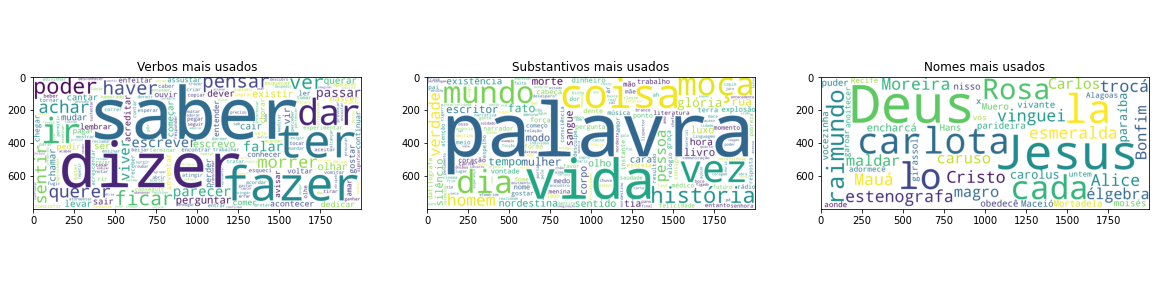

In [119]:
fig = plt.figure(figsize=(20,5))
plt.axis("off")
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(wordcloud_verbos)
ax1.set_title('Verbos mais usados')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(wordcloud_subs)
ax2.set_title('Substantivos mais usados')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(wordcloud_nomes)
ax3.set_title('Nomes mais usados')


plt.show()

No plot de nomes mais usados, encontramos alguns personagens presentes nos livros:
- Carlota, que se refere à Madame Carlota, de "A hora da estrela"
- Jesus, que pode se referir à Olímpico de Jesus

Já a palavra Deus também aparece com muita frequência. Isto pois muitas obras de Clarice são recheadas de questões religiosas, pondo sempre em foco o ser humano. Um exemplo disto é o conto "Perdoando a Deus", presente no livro "Todos os contos".


### N-grams

Outra análise que podemos fazer é em relação aos *n-grams*. Isto é, podemos fazer uma análise de frequência em que *n* palavras aparecem juntas. Aqui, vamos analisar *n-grams* de 2 palavras.

Para facilitar um pouco a visualização, iremos ver apenas os 10 bigramas mais comuns.

<AxesSubplot:>

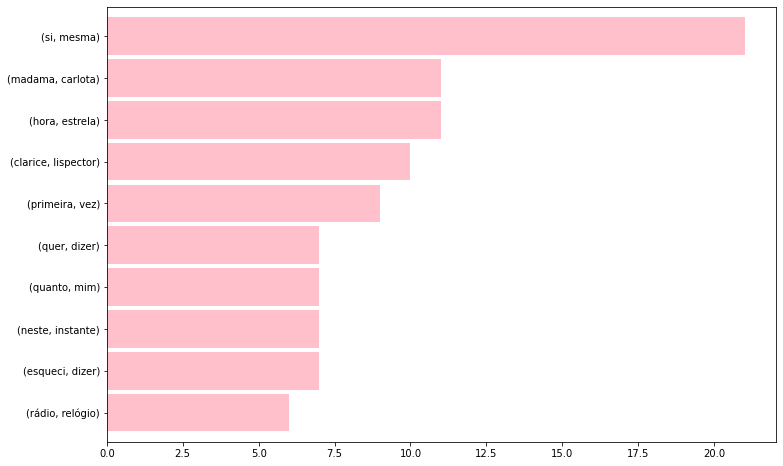

In [120]:
bigrams = (pd.Series(nltk.ngrams(palavras, 2)).value_counts())[:10]
bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(12, 8))

Nos bigramas mais comuns, podemos ver coisas como nomes de personagens (Madama e Carlota), nome do livro (Hora, Estrela), conectivos utilizados (Neste, Instante), e (Si,Mesma), que demonstra a intimicidade já conhecida das obras de Lispector.

### Classes gramaticais presentes



Outra análise que podemos fazer é ver o número de classes gramaticais presentes. Para isso, vamos usar novamente a biblioteca do Spacy. Para facilitar a análise, vamos excluir a classe gramatical de pontuações.


<AxesSubplot:>

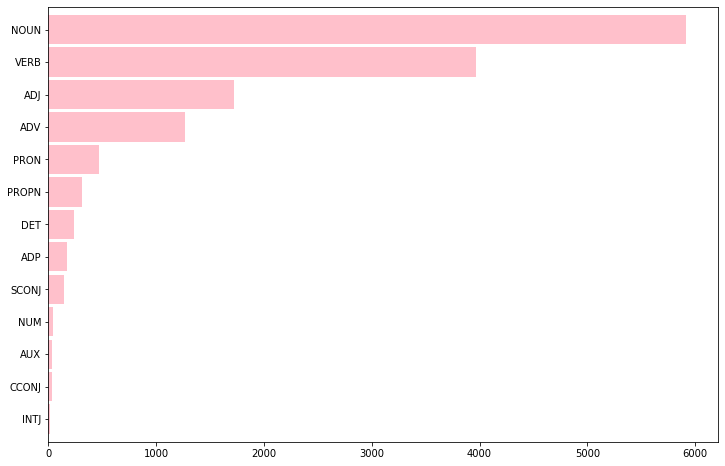

In [121]:
pos_tags = pd.Series([token.pos_ for token in doc if token.pos_ != "PUNCT"]).value_counts()
pos_tags.sort_values().plot.barh(color='pink', width=.9, figsize=(12, 8))

Com isso, vemos que os textos de Clarice possuem uma predominância de substantivos, verbos e adjetivos, mas com poucos nomes próprios e pronomes. Esses dados refletem nas obras, em que o psicológico dos personagens é comumente tematizado, abusando de adjetivos e pensamentos.

## Word2Vec

Agora, vamos usar o Word2Vec para nos auxiliar com algumas análises. Com ele, podemos manipular as palavras como se fossem números, a partir de seus embeddings.

### Utilizando nosso conjunto de dados

A priori, vamos usar o nosso próprio conjunto de dados para treinar o modelo.

Para treinar o modelo, devemos enviar listas de palavras. Para isso, vamos pegar o array palavras e dívidi-lo em listas com 2 palavras cada.

In [143]:
sent = np.array_split(palavras,7110.0)
sent = [l.tolist() for l in sent]
sent

[['hora', 'estrela'],
 ['clarice', 'lispector'],
 ['hora', 'estrela'],
 ['culpa', 'hora'],
 ['estrela', 'arranje'],
 ['direito', 'grito'],
 ['quanto', 'futuro'],
 ['lamento', 'blue'],
 ['sabe', 'gritar'],
 ['assovio', 'vento'],
 ['escuro', 'posso'],
 ['fazer', 'nada'],
 ['registro', 'fatos'],
 ['antecedentes', 'história'],
 ['lacrimogênica', 'cordel'],
 ['saída', 'discreta'],
 ['porta', 'fundos'],
 ['apresentação', 'escrever'],
 ['estrelas', 'ora'],
 ['direis', 'clarice'],
 ['lispector', 'deixou'],
 ['vários', 'depoimentos'],
 ['sobre', 'produção'],
 ['literária', 'alguns'],
 ['parecia', 'defender'],
 ['estranhamento', 'causava'],
 ['leitores', 'críticos'],
 ['consciência', 'diferença'],
 ['desde', 'pequena'],
 ['ver', 'recusadas'],
 ['histórias', 'mandava'],
 ['jornal', 'recife'],
 ['pressentia', 'porque'],
 ['nenhuma', 'contava'],
 ['fatos', 'necessários'],
 ['história', 'nenhuma'],
 ['relatava', 'acontecimento'],
 ['sabia', 'adulta'],
 ['poderia', 'tornar'],
 ['atraente', 'texto'],


Agora, vamos definir um modelo do Word2Vec

In [144]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

E vamos, finalmente, adicionar vocabulário

In [145]:
w2v_model.build_vocab(sent, progress_per=10000)
w2v_model.wv.key_to_index

{'porque': 0,
 'macabéa': 1,
 'pois': 2,
 'vida': 3,
 'palavra': 4,
 'ter': 5,
 'tudo': 6,
 'nada': 7,
 'história': 8,
 'sei': 9,
 'moça': 10,
 'nunca': 11,
 'coisa': 12,
 'tão': 13,
 'si': 14,
 'assim': 15,
 'mim': 16,
 'dizer': 17,
 'sim': 18,
 'vez': 19,
 'mundo': 20,
 'sabia': 21,
 'bem': 22,
 'glória': 23,
 'então': 24,
 'agora': 25,
 'olímpico': 26,
 'dia': 27,
 'havia': 28,
 'homem': 29,
 'verdade': 30,
 'disse': 31,
 'deus': 32,
 'enquanto': 33,
 'sempre': 34,
 'sabe': 35,
 'vai': 36,
 'mesma': 37,
 'pouco': 38,
 'menos': 39,
 'grande': 40,
 'apenas': 41,
 'ainda': 42,
 'escritor': 43,
 'dava': 44,
 'tempo': 45,
 'embora': 46,
 'sobre': 47,
 'pessoa': 48,
 'escrever': 49,
 'quero': 50,
 'vezes': 51,
 'outra': 52,
 'hora': 53,
 'quase': 54,
 'todos': 55,
 'corpo': 56,
 'todo': 57,
 'tanto': 58,
 'ninguém': 59,
 'coisas': 60,
 'sangue': 61,
 'livro': 62,
 'morte': 63,
 'modo': 64,
 'tia': 65,
 'meio': 66,
 'rua': 67,
 'outro': 68,
 'fazer': 69,
 'mulher': 70,
 'ver': 71,
 'vou': 

E agora, podemos treinar nosso modelo.

In [146]:
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


(8471, 426600)

Agora, podemos fazer alguns testes para validar nossos embeddings. O primeiro teste que faremos será a distância de cossenos entre os embeddings de "Macabéa" e "Olímpico". Aqui, quanto mais próximo de 1, maior a similaridade entre os nossos embeddings.

In [148]:
w2v_model.wv.distance('macabéa','olímpico')

0.994846373796463

Como esperado, a similaridade obtida é alta, uma vez que Macabéa e Olímpico são um ""par"" em "A hora da estrela".

Também podemos fazer a distância euclidiana dessas palavras.

In [149]:
np.linalg.norm(w2v_model.wv['palavra'] - w2v_model.wv['escrever'])

0.07966077

Aqui, a distância euclidiana das palavras é baixa, sinalizando a similaridade entre elas.

Outra coisa que podemos verificar são as palavras mais similares em relação à outra.

In [150]:
w2v_model.wv.most_similar(positive=["história"])


[('dia', 0.2993881404399872),
 ('outra', 0.24214047193527222),
 ('pois', 0.2288215160369873),
 ('explosão', 0.21094125509262085),
 ('dava', 0.19069448113441467),
 ('pessoa', 0.18224401772022247),
 ('sobre', 0.17106352746486664),
 ('falar', 0.17023850977420807),
 ('livro', 0.15569734573364258),
 ('ver', 0.14912207424640656)]

E também podemos achar o que menos se encaixa entre uma lista de palavras do vocabulário

In [154]:
w2v_model.wv.doesnt_match(['macabéa', 'explosão', 'olímpico'])


'explosão'

Esses testes parecem muito bons, mas, quando vamos testar algumas semelhanças entre palavras com um significado parecido, temos resultados pouco satisfatórios.

In [155]:
w2v_model.wv.most_similar(positive=["vida"])

[('ver', 0.20423831045627594),
 ('si', 0.1779285967350006),
 ('vou', 0.16394688189029694),
 ('vai', 0.16356000304222107),
 ('tempo', 0.14957574009895325),
 ('quanto', 0.13779953122138977),
 ('falar', 0.13490407168865204),
 ('corpo', 0.13472458720207214),
 ('ter', 0.13272759318351746),
 ('tanto', 0.12322933226823807)]

Isto, pois, quando treinamos um modelo de embedding a partir de livros, o modelo acaba por levar em conta o contexto. Assim, mesmo que não sejam palavras parecidas, elas são encontradas frequentemente em contextos parecidos.

### Carregando um modelo do NILC

A partir de agora, vamos testar alguns modelos pré-treinados disponibilizados no NILC. Vamos utilizar 3 modelos: com 50, 300 e 1000 posições vetoriais.

In [ ]:
from gensim.models import KeyedVectors

Vamos começar testando o modelo com 50 dimensões

In [ ]:
model_50 = KeyedVectors.load_word2vec_format("cbow_s50/cbow_s50.txt")

Vamos fazer alguns testes parecidos, e outros mais focados na similaridade das palavras. Começando com os testes feitos para o nosso modelo, temos:

In [ ]:
model_50.distance('macabéa','olímpico')

0.8036423921585083

In [ ]:
np.linalg.norm(model_50['macabéa'] - model_50['olímpico'])

2.5691442

In [ ]:
model_50.most_similar(positive=["glória"])

[('ressureição', 0.8563553690910339),
 ('viscondessa', 0.8303345441818237),
 ('morgada', 0.8292663097381592),
 ('cachola', 0.8285811543464661),
 ('expectação', 0.8280422687530518),
 ('princeza', 0.8252332210540771),
 ('auctoridade', 0.8210678696632385),
 ('consolação', 0.8173748850822449),
 ('innocencia', 0.8172270059585571),
 ('ressurreição', 0.8168944716453552)]

In [ ]:
model_50.doesnt_match(['macabéa', 'olímpico', 'morte'])


'olímpico'

Agora, os resultados se apresentam de forma bem diferente. Quando fazemos esses testes para palavras do livro, obtemos resultados que não possuem contexto fixado nas obras de Lispector. Porém, quando queremos palavras que tem significado similar, o resultado é satisfatório.

In [ ]:
model_50.most_similar(positive=["moça"])

[('menina', 0.9310055375099182),
 ('mulatinha', 0.9054270386695862),
 ('donzela', 0.8990174531936646),
 ('mulata', 0.8980569243431091),
 ('égua', 0.894492506980896),
 ('cadelinha', 0.8927095532417297),
 ('mocinha', 0.8922073841094971),
 ('loira', 0.892098605632782),
 ('ricaça', 0.8900133967399597),
 ('rapariga', 0.8834722638130188)]

Porém, vamos notar que, com a medida que as posições vetoriais crescem, as contextualizações também crescem e mudam.

In [71]:
model_300 = KeyedVectors.load_word2vec_format("cbow_s300/cbow_s300.txt")

In [72]:
model_300.most_similar(positive=["glória"])

[('formosura', 0.5699642896652222),
 ('felicidade', 0.5674874782562256),
 ('glã³ria', 0.5519635677337646),
 ('sabedoria', 0.5500460863113403),
 ('innocencia', 0.5491595268249512),
 ('graça', 0.5475744009017944),
 ('piedade', 0.5217739343643188),
 ('auto-existência', 0.5181103944778442),
 ('bondade', 0.5136435031890869),
 ('dôr', 0.5032995939254761)]

Enquanto no modelo com 50 posições vetoriais, a palavra glória estava relacionada com títulos e era vista como um nome próprio, aqui glória assume o papel de um adjetivo, e as palavras similares são outros adjetivos.

In [73]:
model_300.distance('macabéa','olímpico')

0.9637558422982693

In [74]:
model_1000 = KeyedVectors.load_word2vec_format("cbow_s1000/cbow_s1000.txt")

In [ ]:
model_1000.distance('macabéa','olímpico')

In [ ]:
model_1000.most_similar(positive=["glória"])

O mesmo ocorre para 1000 posições vetoriais, mas com ainda mais precisão.

### Treinando embeddings de frases

Agora, vamos treinar alguns embeddings para frases. Para isso, vamos começar analisando bigramas presentes nas palavras. Lembra que lá em cima vimos alguns bigramas presentes no texto?

In [156]:
from gensim.models import phrases, word2vec

Aqui, vamos usar a biblioteca do Gensim para identificar bigramas em nossas frases

In [157]:
bigrams = phrases.Phrases(sent)

Abaixo, podemos verificar que o algoritmo está identificando um bigrama que, previamente, foi tido como comum no texto

In [159]:
print(bigrams["si","mesma","clarice"])

['si_mesma', 'clarice']


Agora, vamos seguir o mesmo esquema e treinar o modelo novamente.

In [160]:
w2v_model_sent = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [161]:
w2v_model_sent.build_vocab(bigrams[sent], progress_per=10000)

In [162]:
w2v_model_sent.train(bigrams[sent], total_examples=w2v_model_sent.corpus_count, epochs=30, report_delay=1)

(8386, 425640)

Para facilitar um pouco a análise, vamos visualizar o nosso modelo por meio do TSNE

In [163]:
from sklearn.manifold import TSNE

c:\Users\mrggi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mrggi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


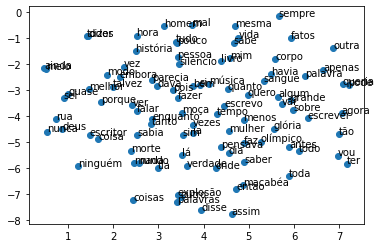

In [164]:
vocab = list(w2v_model_sent.wv.key_to_index)
X = w2v_model_sent.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()

# Bert

In [ ]:
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForMaskedLM  # or BertModel, for BERT without pretraining heads

model = AutoModelForMaskedLM.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import pipeline

pipe = pipeline('fill-mask', model=model, tokenizer=tokenizer)

RuntimeError: Numpy is not available

Referencias

https://www.alura.com.br/artigos/lemmatization-vs-stemming-quando-usar-cada-uma

https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook
